In [ ]:
# Exploratory Data Analysis: Predict Nike Proyect

# This notebook presents an exploratory data analisys of the "Nike Sales Uncleaned Dataset", wich was retrieved from Keggel.
# Data source: Kaggle – Nike Sales (Uncleaned): (https://www.kaggle.com/datasets/nayakganesh007/nike-sales-uncleaned-dataset)

# Project objective:
# The main goals of this project are:
# -Clean and preprocess raw sales data
# -Analyze sales by product, region, and category
# -Forecast monthly revenue using SARIMA modeling
# -Segment products using K-Means clustering based on performance metrics

In [2]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load dataset
db = pd.read_csv("Nike_Sales_Uncleaned.csv")

db.head()

,Order_ID,Gender_Category,Product_Line,Product_Name,Size,Units_Sold,MRP,Discount_Applied,Revenue,Order_Date,Sales_Channel,Region,Profit
0,2000,Kids,Training,SuperRep Go,M,NaN,NaN,0.47,0.0,2024-03-09,Online,bengaluru,-770.45
1,2001,Women,Soccer,Tiempo Legend,M,3.0,4957.93,NaN,0.0,2024-07-09,Retail,Hyd,-112.53
2,2002,Women,Soccer,Premier III,M,4.0,NaN,NaN,0.0,NaN,Retail,Mumbai,3337.34
3,2003,Kids,Lifestyle,Blazer Mid,L,NaN,9673.57,NaN,0.0,04-10-2024,Online,Pune,3376.85
4,2004,Kids,Running,React Infinity,XL,NaN,NaN,NaN,0.0,2024/09/12,Retail,Delhi,187.89


In [4]:
# Dataset Overview
def summary_db (db):
    summary = pd.DataFrame()
    summary["Data type"] = db.dtypes
    summary["Missing"] = round(db.isnull().mean() * 100, 2)
    summary["Unique values"] = db.nunique()
    
    numeric_db = db.select_dtypes(include=[np.number])
    summary["Mean"] = numeric_db.mean()
    summary["Median"] = numeric_db.median()
    summary["Std dev"] = numeric_db.std()
    summary["Min"] = numeric_db.min()
    summary["Max"] = numeric_db.max()
    
    return summary

summary_db(db)

# Observation
# The Order_Date column had multiple formats and around 24.6% missing values.
# Columns like Units_Sold (49.9% missing), MRP (50.1% missing), and Discount_Applied (66.7% missing) have high rates of nulls.
# Units_Sold contains negative values, wich likely represent data entry errors.
# Revenue also contains negative values, possibly due to miscalculations.
# Several columns such as Gender_Category, Product_Line, and Sales_Channel are categorical but currently loaded as object and should be converted to category type.

,Data type,Missing,Unique values,Mean,Median,Std dev,Min,Max
Order_ID,int64,0.00,2386,3194.352400,3192.500,749.972638,2000.00,4499.00
Gender_Category,object,0.00,3,NaN,NaN,NaN,NaN,NaN
Product_Line,object,0.00,5,NaN,NaN,NaN,NaN,NaN
Product_Name,object,0.00,20,NaN,NaN,NaN,NaN,NaN
Size,object,20.40,10,NaN,NaN,NaN,NaN,NaN
Units_Sold,float64,49.40,6,1.482213,2.000,1.696947,-1.00,4.00
MRP,float64,50.16,1244,6039.863395,6110.030,2315.746826,2006.63,9996.22
Discount_Applied,float64,66.72,126,0.631022,0.615,0.365500,0.00,1.25
Revenue,float64,0.00,167,274.873716,0.000,2023.773550,-7561.59,37169.35
Order_Date,object,24.64,1008,NaN,NaN,NaN,NaN,NaN


In [5]:
# Data Cleaning and Preprocessing
db["Order_Date"] = pd.to_datetime(db["Order_Date"], errors = "coerce")

db = db.dropna(subset = ["Order_Date","Revenue"])

db = db[db["Revenue"] > 0]

db["Region"] = db["Region"].replace({
    "Delhii" : "Delhi",
    "Banglore": "Bangalore",
    "Hyd": "Hyderabad",
    "bengaluru": "Bangalore"})

db.loc[db["Discount_Applied"] > 1.0, "Discount_Applied"] = 1.0

category_cols = ["Gender_Category", "Product_Line", "Product_Name", "Size", "Sales_Channel", "Region"]
for col in category_cols:
    db[col] = db[col].astype("category")
    
db.reset_index(drop = True, inplace = True)

summary_db(db)

# Observation
# All valid "Order_Date" values were parsed and coerced to "NaT", then dropped.
# Only records with valid and positive "Revenue" were retained.
# Obvious typos in the "Region" columns were corrected.
# "Discount_Applied" values over 1.0 were capped.
# Categorical columns were converted to "category".

,Data type,Missing,Unique values,Mean,Median,Std dev,Min,Max
Order_ID,int64,0.00,27,3056.296296,2912.00,767.787772,2003.00,4410.00
Gender_Category,category,0.00,3,NaN,NaN,NaN,NaN,NaN
Product_Line,category,0.00,5,NaN,NaN,NaN,NaN,NaN
Product_Name,category,0.00,15,NaN,NaN,NaN,NaN,NaN
Size,category,18.52,7,NaN,NaN,NaN,NaN,NaN
Units_Sold,float64,0.00,5,1.851852,2.00,1.231125,-1.00,4.00
MRP,float64,0.00,27,6779.998889,6546.59,2081.055375,2767.55,9839.63
Discount_Applied,float64,0.00,24,0.541852,0.58,0.328154,0.04,1.00
Revenue,float64,0.00,27,6379.394444,4612.57,6305.424493,157.68,25079.88
Order_Date,datetime64[ns],0.00,27,NaN,NaN,NaN,NaN,NaN


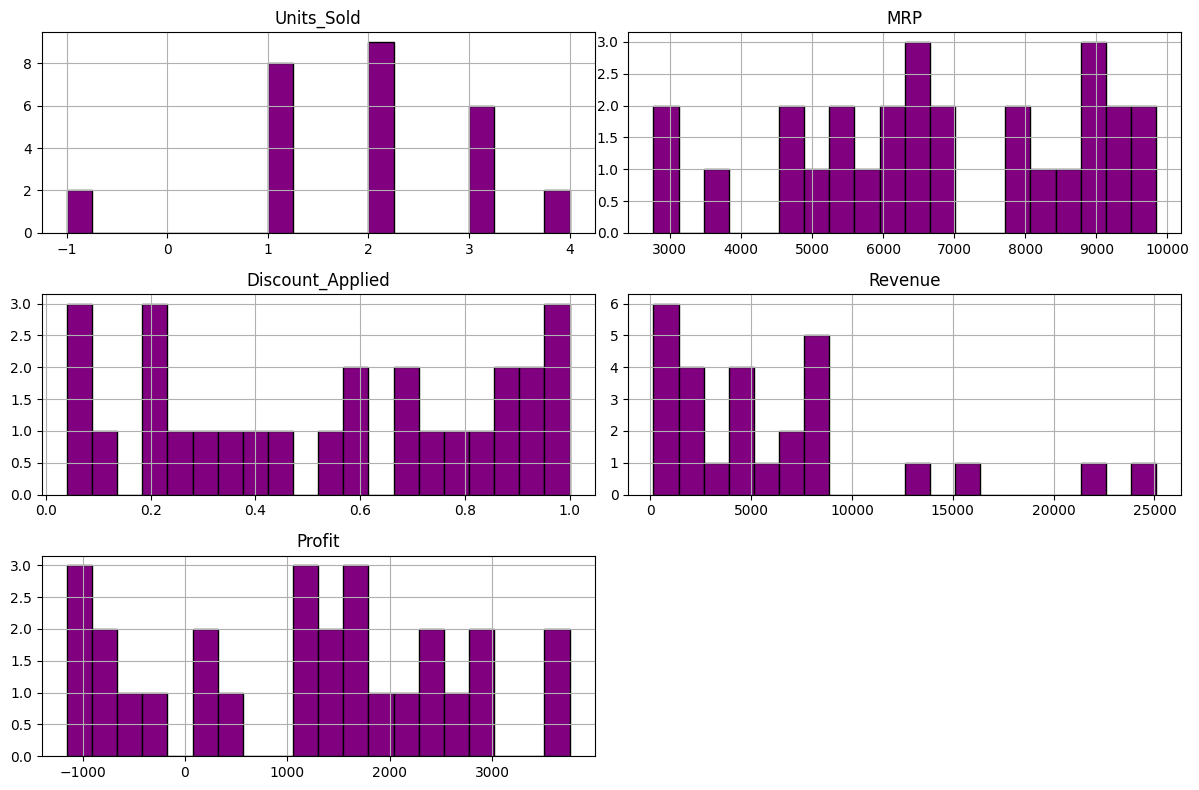

In [6]:
# Exploratory Data Analysis

# Distribution of numerical variables
num_cols = ["Units_Sold", "MRP", "Discount_Applied", "Revenue", "Profit"]
db[num_cols].hist(figsize=(12,8), bins = 20, color = "purple", edgecolor = "black")
plt.title("Distribution of Numerical Features")
plt. tight_layout()
plt.show()

# Interpretation
# Units_Sold: Most values are concentrated around 1 to 3 units.
# MRP: Prices are spread between 3,000 and 10,000, with clusters around 6,000-7,000 and 9,000.
# Discount_Applied: Discounts vary significantly, with peaks near 0, 0.2 and 1.0. 
# Profit: Profit values range from highly negative to moderately high positive. 

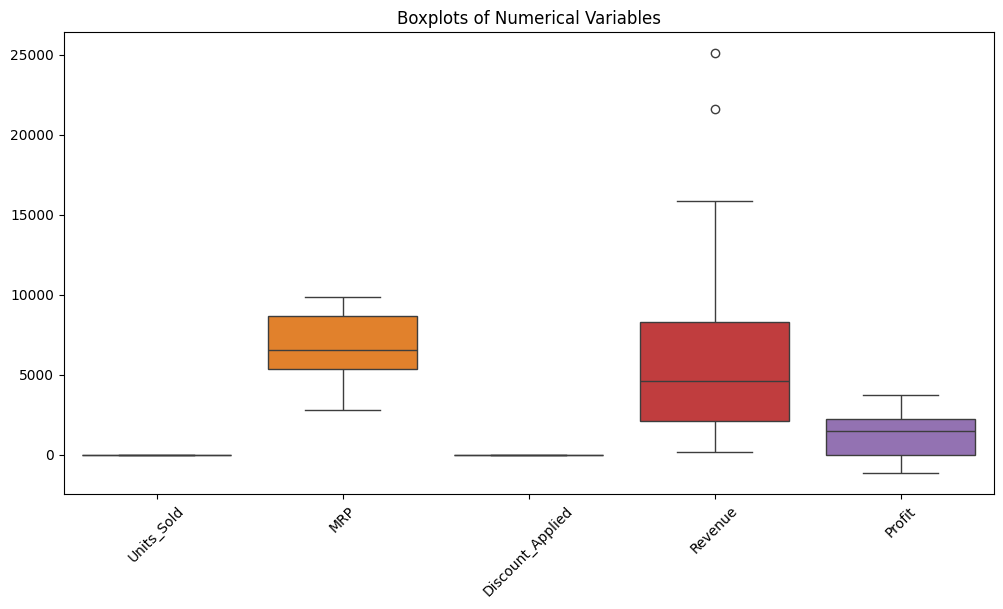

In [7]:
# Boxplots for outliers detection
plt.figure(figsize = (12,6))
sns.boxplot(data = db[num_cols])
plt.title("Boxplots of Numerical Variables")
plt.xticks(rotation = 45)
plt.show()

# Interpretation
# Units_Sold: Most values are centered, but the presence of a negative value.
# MRP: Prices are relatively well distributed, with a few high-price values but no extreme outliers.
# Discount_Applied: Distribution is tight with few extreme values.
# Revenue: Shows significant variability and multiple outliers above 15,000 and even over 25,000.
# Profit: Displays a wide range, including negative values, pointing to losses in some transactions. 

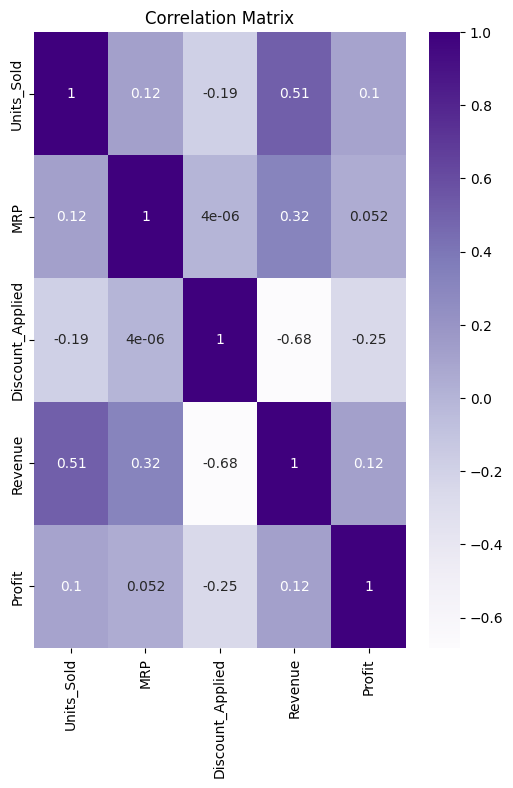

In [8]:
# Correlation Matrix
plt.figure(figsize = (6,8))
sns.heatmap(db[num_cols].corr(), annot = True, cmap = "Purples")
plt.title("Correlation Matrix")
plt.show()

# Interpretation
# Units_Sold and Revenue show a moderate positive correlation of 0.51, since selling more units generally increases revenue.
# Discount_Applied has a strong negative correlation with Revenue of -0.68, indicating that higher discounts significantly reduce overall revenue.
# MRP is weakly correlated with Revenue, 0.32, and Units_Sold, 0.12, suggesting that price alone does not strongly drive either.
# Profit has weak correlations with all variables, including Discount_Applied with -0.25, implying that other unobserved factors may influence profit variability.

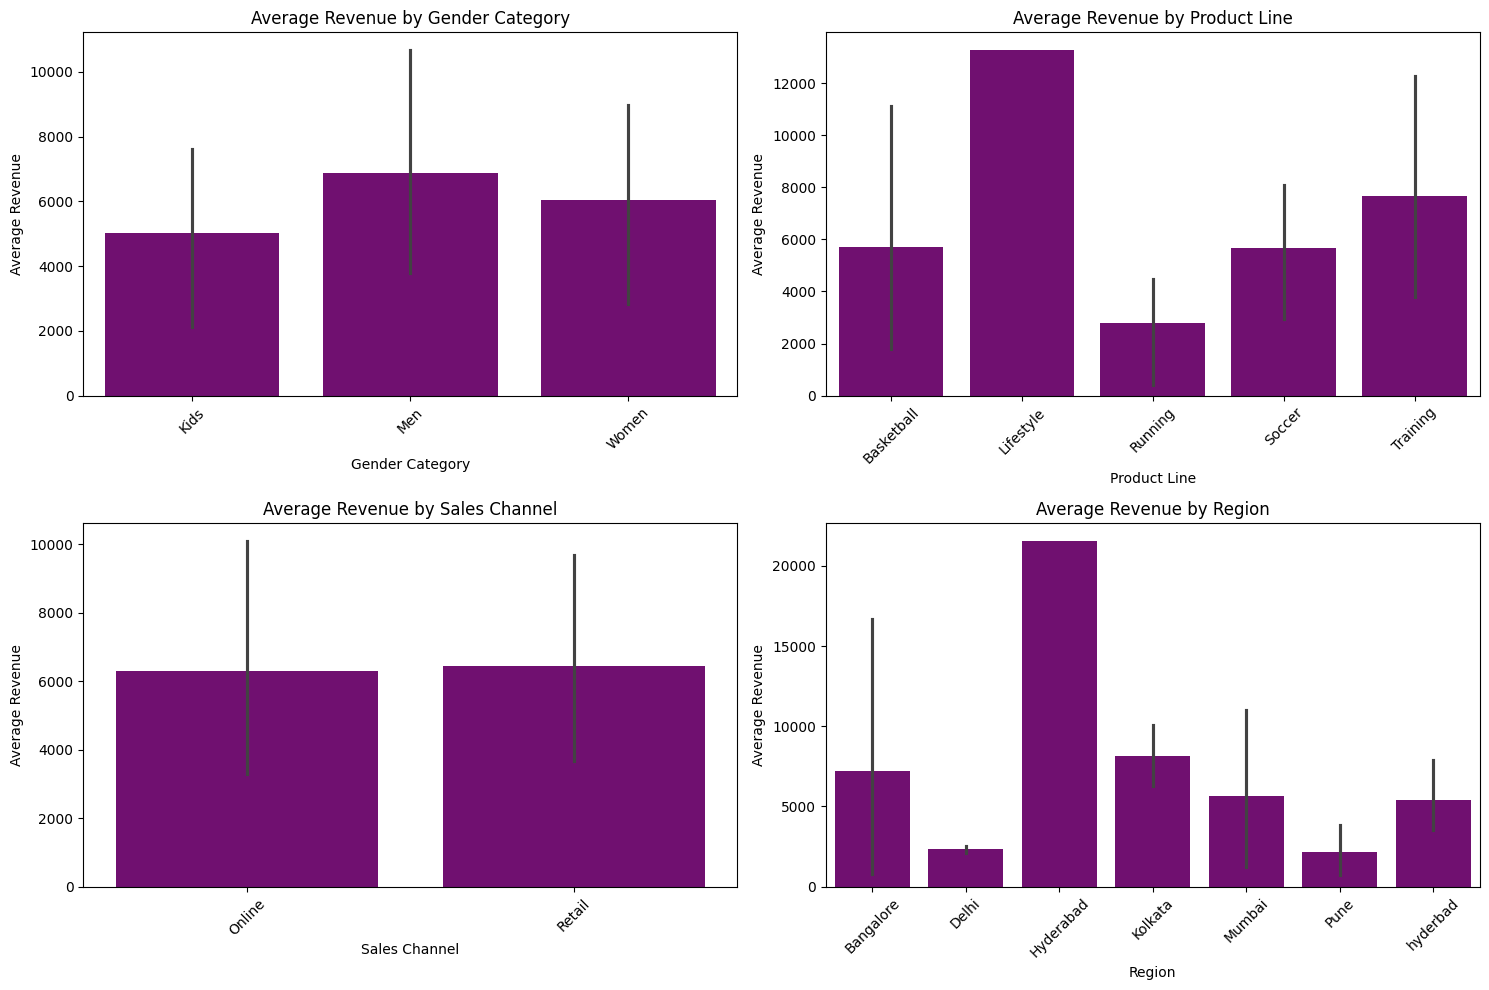

In [9]:
# Average revenue by category
cat_cols = ["Gender_Category", "Product_Line", "Sales_Channel", "Region"]
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.barplot(data=db, x=col, y="Revenue", estimator=np.mean, ax=axes[i], color="purple")
    axes[i].set_title(f"Average Revenue by {col.replace("_", " ")}")
    axes[i].set_ylabel("Average Revenue")
    axes[i].set_xlabel(col.replace("_", " "))
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Interpretation
# Gender: Men's products generate the highest average revenue, followed by Women's and Kids'.
# Product Line: The Lifestyle line leads with the highest average revenue, while Running products generate the least.
# Sales Channel: Revenue is nearly equal between Online and Retail channels.
# Region: Hyderabad shows higher average revenue, possibly due to outliers or a high-volume customer base. In contrast, Delhi and Pune show lower average revenue.

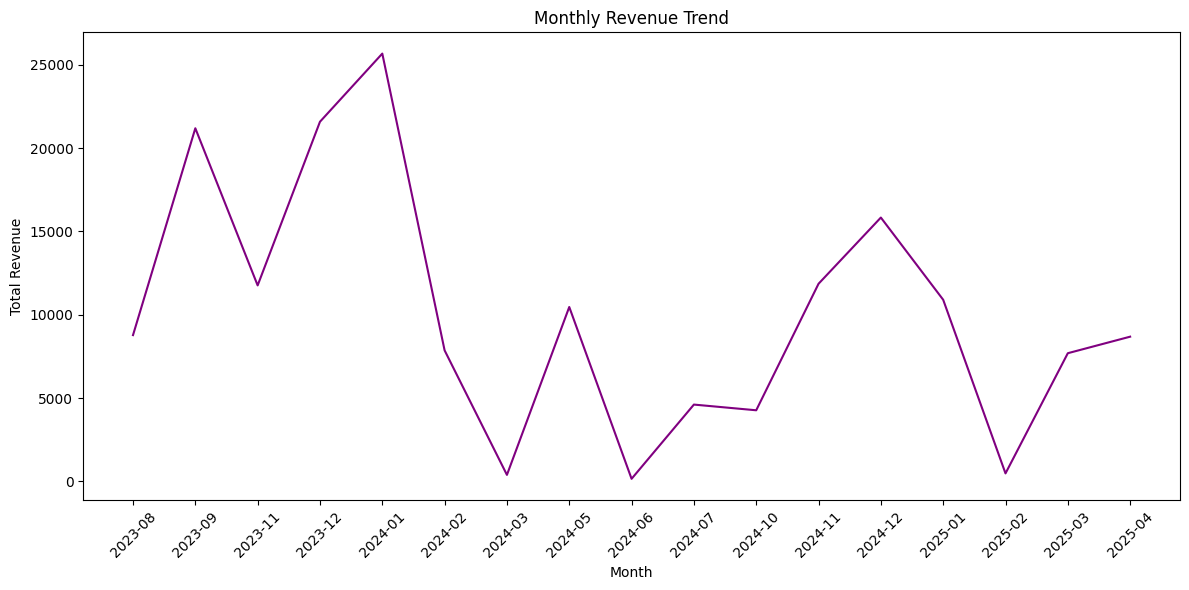

In [10]:
# Revenue trend over time
db["Month"] = db["Order_Date"].dt.to_period("M").astype(str)
monthly_revenue = db.groupby("Month")["Revenue"].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_revenue, x="Month", y="Revenue", color="purple")
plt.xticks(rotation=45)
plt.title("Monthly Revenue Trend")
plt.ylabel("Total Revenue")
plt.xlabel("Month")
plt.tight_layout()
plt.show()

# Interpretation
# The highest revenue was recorded in January 2024, followed by strong performance in December and September 2023.
# There’s a sharp decline in revenue after January 2024, reaching near zero in March and June 2024.
# A recovery phase is seen starting in July 2024, peaking again in December 2024.

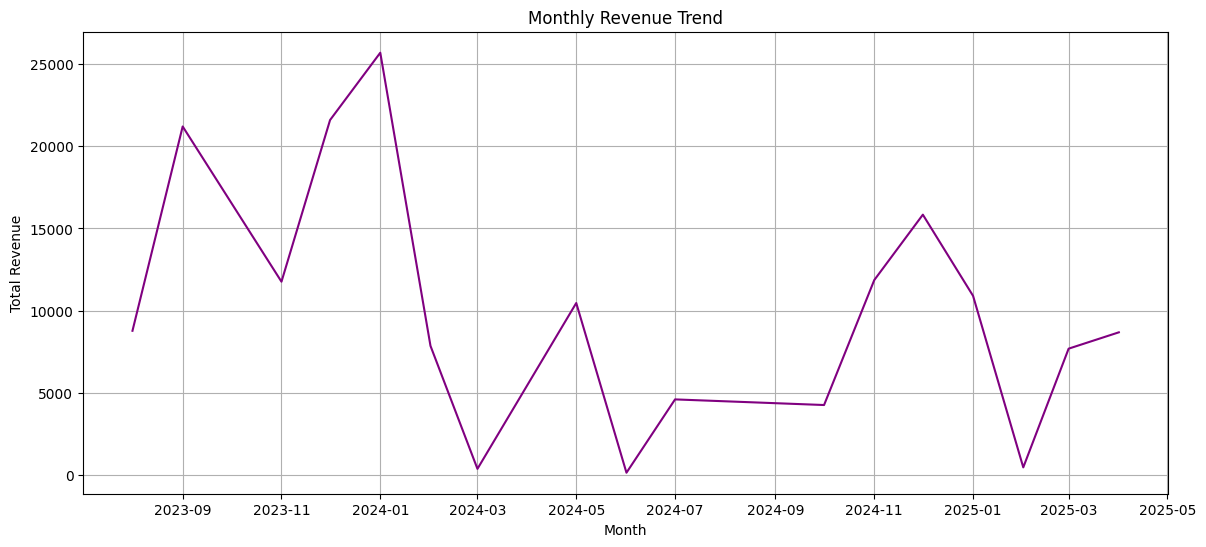

In [ ]:
# Time Series Analysis and Forecasting Preparation
monthly_revenue_series = db.groupby(db["Order_Date"].dt.to_period("M"))["Revenue"].sum()
monthly_revenue_series.index = monthly_revenue_series.index.to_timestamp()

monthly_revenue_df = monthly_revenue_series.to_frame(name="Revenue")
monthly_revenue_df.index.name = "Month"

# Revenue trend over time
plt.figure(figsize=(14,6))
plt.plot(monthly_revenue_df["Revenue"], color="purple")
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.grid(True)
plt.show()

# Interpretation
# At first glance, the line plot of monthly revenue suggests a non-stacionary pattern due to noticeable trends and fluctuations over time.
# To confirm this, the Augmented Dickey-Fuller (ADF) test is applied.

In [12]:
# Augmented Dickey-Fuller (ADF) test
from statsmodels.tsa.stattools import adfuller

result = adfuller(monthly_revenue_df["Revenue"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

# The test resulted in a test statistic of -2.67 and p-value of 0.078, which is higher than significance level of 0.05.
# Therefore, we fail to reject the null hypothesis of non-stationarity, indicating that the time series is not stationary and must be transformed before applying forecasting models.

ADF Statistic: -2.673993864805787
p-value: 0.07864758717478612


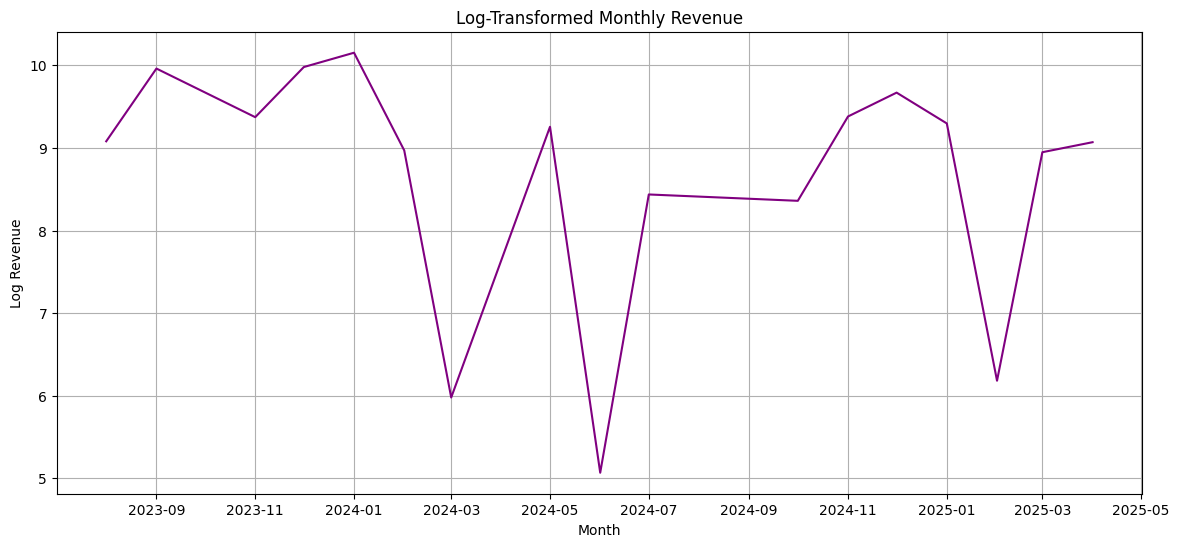

ADF Statistic (Log): -3.730317494606847
p-value: 0.0037063666500604304


In [ ]:
# Log transformation 
log_series = np.log1p(monthly_revenue_df["Revenue"])

plt.figure(figsize=(14,6))
plt.plot(log_series, color="purple")
plt.title("Log-Transformed Monthly Revenue")
plt.xlabel("Month")
plt.ylabel("Log Revenue")
plt.grid(True)
plt.show()

result_log = adfuller(log_series.dropna())
print(f"ADF Statistic (Log): {result_log[0]}")
print(f"p-value: {result_log[1]}")

# Interpretation:
# Log transformation alone yields a stationary series, ADF p-value (0.003) < 0.05, reducing variance but not fully eliminating trend.

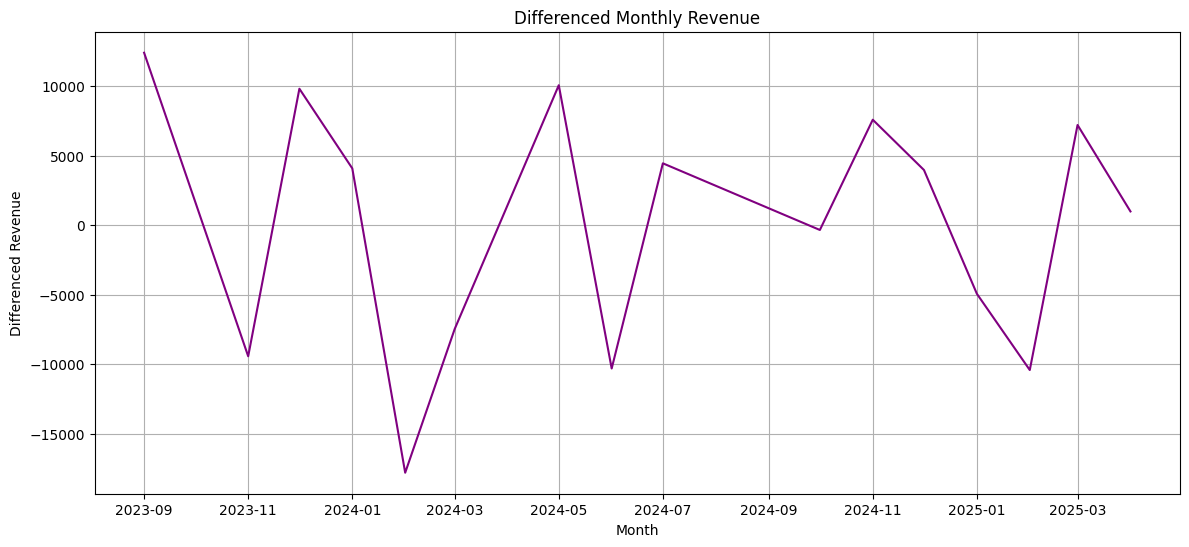

ADF Statistic (Diff): -2.364144150526637
p-value: 0.15211317787223527


In [ ]:
# Difference
diff_series = monthly_revenue_df["Revenue"].diff()

plt.figure(figsize=(14, 6))
plt.plot(diff_series, color="purple")
plt.title("Differenced Monthly Revenue")
plt.xlabel("Month")
plt.ylabel("Differenced Revenue")
plt.grid(True)
plt.show()

result_diff = adfuller(diff_series.dropna())
print(f"ADF Statistic (Diff): {result_diff[0]}")
print(f"p-value: {result_diff[1]}")

# Interpretation:
# Differencing alone does not achieve stationarity, ADF p-value (0.15) > 0.05.

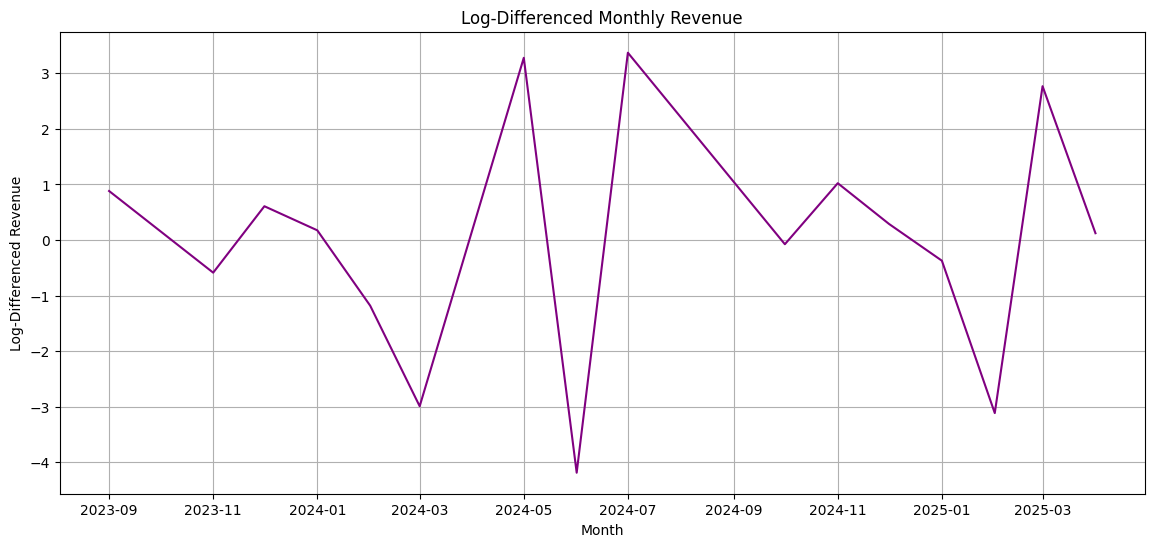

ADF Statistic (Log-Diff): -7.3234536414219145
p-value: 1.1776493797200085e-10


In [ ]:
# Log and difference
log_diff_series = np.log1p(monthly_revenue_df["Revenue"]).diff()

plt.figure(figsize=(14, 6))
plt.plot(log_diff_series, color="purple")
plt.title("Log-Differenced Monthly Revenue")
plt.xlabel("Month")
plt.ylabel("Log-Differenced Revenue")
plt.grid(True)
plt.show()

result_log_diff = adfuller(log_diff_series.dropna())
print(f"ADF Statistic (Log-Diff): {result_log_diff[0]}")
print(f"p-value: {result_log_diff[1]}")

# Interpretation:
# Log-differencing results in a highly stationary series, ADF p-value (1.177-10) < 0.05.

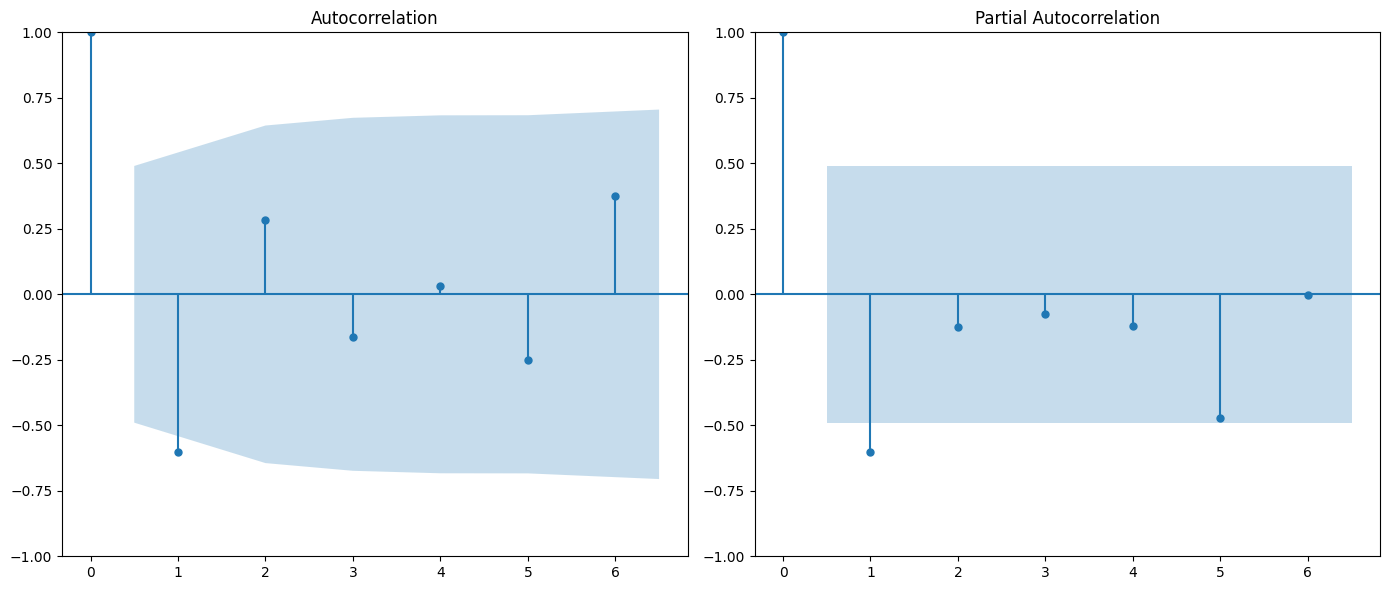

In [16]:
# ACF and PACF plots are used to determine the appropriate ARIMA/SARIMA model parameters.
# ACF: Autocorrelation Function, helps identify the Moving Average order "q".
# PACF: Partial Autocorrelation Function, helps identify the Autoregressive order "p".

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plot_acf(log_diff_series.dropna(), ax=plt.gca(), lags=6)
plt.subplot(1,2,2)
plot_pacf(log_diff_series.dropna(), ax=plt.gca(), lags=6, method="ywm")
plt.tight_layout()
plt.show()

# Interpretation
# The ACF shows a significant spike at lag 1, then cuts off gradually, which suggests an MA(1) or MA(2) component.
# The PACF also shows a clear drop after lag 1, indicating a potential AR(1) structure.

In [17]:
#SARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX

log_diff_series_clean = log_diff_series.dropna()

model = SARIMAX(log_series, order=(1, 1, 1), seasonal_order=(1, 0, 1, 12))
model_fit = model.fit(disp=False)

print(model_fit.summary())

# Interpretation
# Ljung-Box test is Q=0.51, p=0.48, no autocorrelation in residuals.
# Jarque-Bera test with p=0.08, residuals roughly normal.
# Heteroskedasticity H=7.21, p=0.05, contain a non-constant variance 
# Skew = -1.36, left-skewed residuals.
# Kurtosis = 3.30, distribution close to normal.

c:\Users\thais\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\thais\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\thais\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                            Revenue   No. Observations:                   17
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 -30.274
Date:                            Sat, 02 Aug 2025   AIC                             70.548
Time:                                    15:36:01   BIC                             74.411
Sample:                                         0   HQIC                            70.745
                                             - 17                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0834      1.088      0.077      0.939      -2.050       2.217
ma.L1         -0.9083      2.369   

In [18]:
# Forecast future values
n_values = 12
forecast_log = model_fit.get_forecast(steps=n_values)
forecast_mean_log = forecast_log.predicted_mean
conf_int_log = forecast_log.conf_int()

c:\Users\thais\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\thais\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


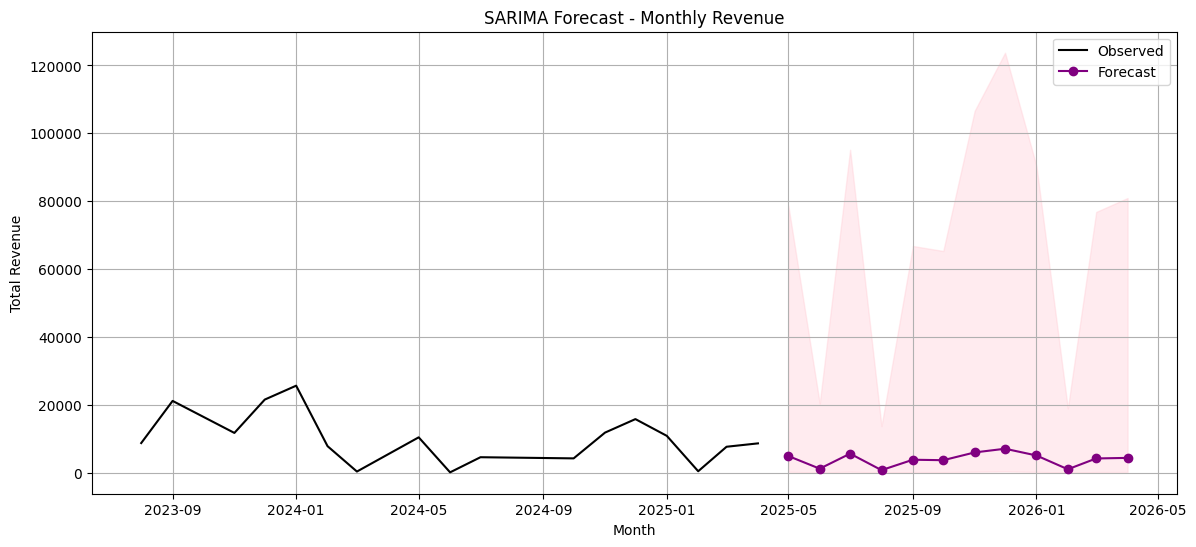

In [19]:
# Convert forecast back to original scale and plot forecast
forecast_original = np.expm1(forecast_mean_log)
conf_int_original = np.expm1(conf_int_log)

last_date = monthly_revenue_df.index[-1]
future_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(), periods=n_values, freq="MS")

plt.figure(figsize=(14, 6))
plt.plot(monthly_revenue_df["Revenue"], label="Observed", color="black")
plt.plot(future_dates, forecast_original, label="Forecast", color="purple", marker="o")
plt.fill_between(future_dates, conf_int_original.iloc[:, 0], conf_int_original.iloc[:, 1], color="pink", alpha=0.3)
plt.title("SARIMA Forecast - Monthly Revenue")
plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.legend()
plt.grid(True)
plt.show()

# Interpretation
# Blue line is historical observed monthly revenue from 2023-08 to 2025-04.
# Red line is forecasted revenue from 2025-05 to 2026-04.
# The forecast suggests moderate monthly revenue growth, with visible uncertainty in later months.

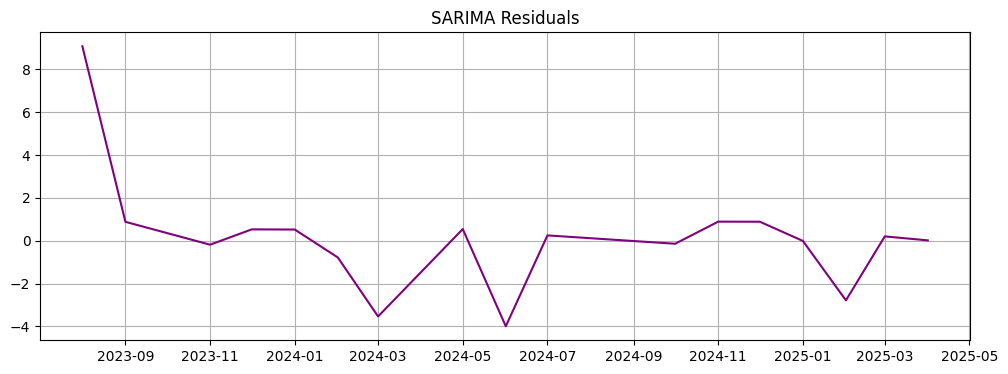

In [20]:
# Residual diagnostics
residuals = model_fit.resid
plt.figure(figsize=(12,4))
plt.plot(residuals, color="purple")
plt.title("SARIMA Residuals")
plt.grid(True)
plt.show()

# Interpretation
# Some variance remains, but residuals generally stay within a ±5 range which is acceptable.

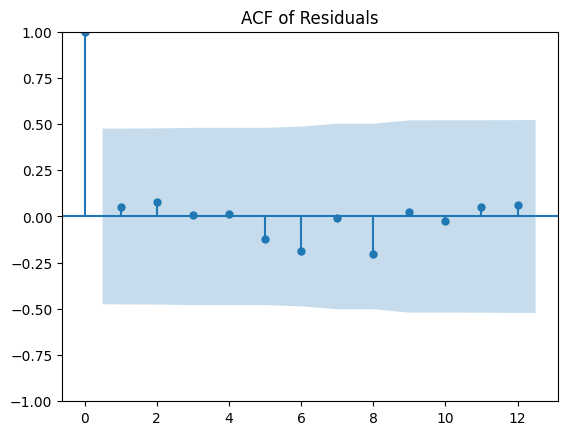

In [21]:
# ACF of residuals
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(residuals.dropna(), lags=12)
plt.title("ACF of Residuals")
plt.show()

# Interpretation
# The lags fall within the 95% confidence interval 

In [22]:
# Ljung-Box test to check for white noise
from statsmodels.stats.diagnostic import acorr_ljungbox

print(acorr_ljungbox(residuals.dropna(), lags=[10], return_df=True))

# Interpretation
# Since p-value > 0.05, 0.978, we fail to reject the null hypothesis, and indicates no significant autocorrelation remains in residuals.

     lb_stat  lb_pvalue
10  3.113558   0.978624


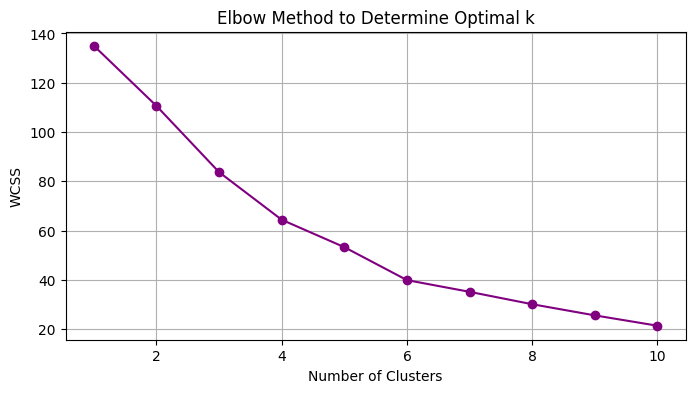

In [23]:
# Clustering
# The elbow method
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

features = ["Units_Sold", "MRP", "Discount_Applied", "Revenue", "Profit"]
X = db[features].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), wcss, marker="o", color="purple")
plt.title("Elbow Method to Determine Optimal k")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.grid(True)
plt.show()

# The elbow method is used to determine the optimal number of clusters in a K-Means segmentation model.

# Interpretation
# The curve begins to flatten at k = 3, forming an "elbow." This indicates that 3 clusters is an appropriate number to segment the Nike products.

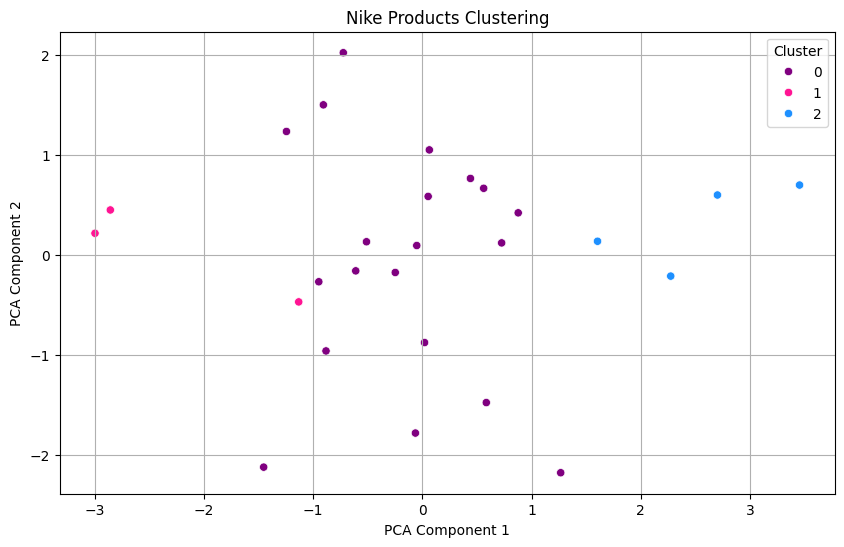

         Units_Sold      MRP  Discount_Applied   Revenue   Profit
Cluster                                                          
0              2.00  6691.06              0.58   4662.70  1387.12
1             -0.33  5279.29              0.82   1066.68  -840.03
2              2.75  8350.22              0.16  18947.38  1597.92


In [24]:
# KMeans
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
clusters = kmeans.fit_predict(X_scaled)
db["Cluster"] = clusters

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
db["PCA1"] = X_pca[:, 0]
db["PCA2"] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=db, x="PCA1", y="PCA2", hue="Cluster",  palette=["purple", "deeppink", "dodgerblue"])
plt.title("Nike Products Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.legend(title="Cluster")
plt.show()

cluster_summary = db.groupby("Cluster")[features].mean().round(2)
print(cluster_summary)

# Interpretation
# Purple Cluster (0): Medium-priced products with moderate discounts and good profit margins, likely your core performers.
# Pink Cluster (1): Low-performing items with heavy discounts, low revenue, and negative profit; these may be unsuccessful or clearance products.
# Blue Cluster (2): High-end products with high MRP and low discount, best revenue and profit likely your premium segment.

In [25]:
# Save database
# db.to_csv("nike_sales_cleaned.csv", index=False)